In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Libraries for recommendation system algorithms
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Libraries for working with JSON data
import json


import sys

In [50]:
# Load the datasets
credits_df = pd.read_csv('tmdb_5000_credits.csv')
movies_df = pd.read_csv('tmdb_5000_movies.csv')

In [51]:
# Display the first few rows of each dataframe
credits_df.head()

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [52]:
movies_df.head()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466  
3                     The Dark Knight Rises           7.6        9106  
4                               John Carter           6.1        2124

In [53]:
# Renaming columns in the credits dataframe
credits_df.columns = ['id', 'title', 'cast', 'crew']

# Merging the movies dataframe with the renamed credits dataframe on 'id'
movies = movies_df.merge(credits_df, on='id')

# Display the first few rows of the merged dataframe
movies.head()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  ... runtime  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   162.0   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   169.0   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   148.0   
3  [{"name": "Legendary Pictures", "id": 923}, {"...  ...   165.0   
4        [{"name": "Walt Disney Pictures", "id": 2}]  ...   132.0   

                                    spoken_languages    status  \
0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1           [{"iso_639_1": "en", "name": "English"}]  Released   
2  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3           [{"iso_639_1": "en", "name": "English"}]  Released   
4           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                    title_x vote_average vote_count  \
0                                    Avatar          7.2      11800   
1  Pirates of the Caribbean: At World's End          6.9       4500   
2                                   Spectre          6.3       4466   
3                     The Dark Knight Rises          7.6       9106   
4                               John Carter          6.1       2124   

                                    title_y  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne /

In [54]:
# Save the merged dataframe to a CSV file
movies.to_csv('merged_df.csv', index=False)

In [55]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

In [56]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

# Visualization

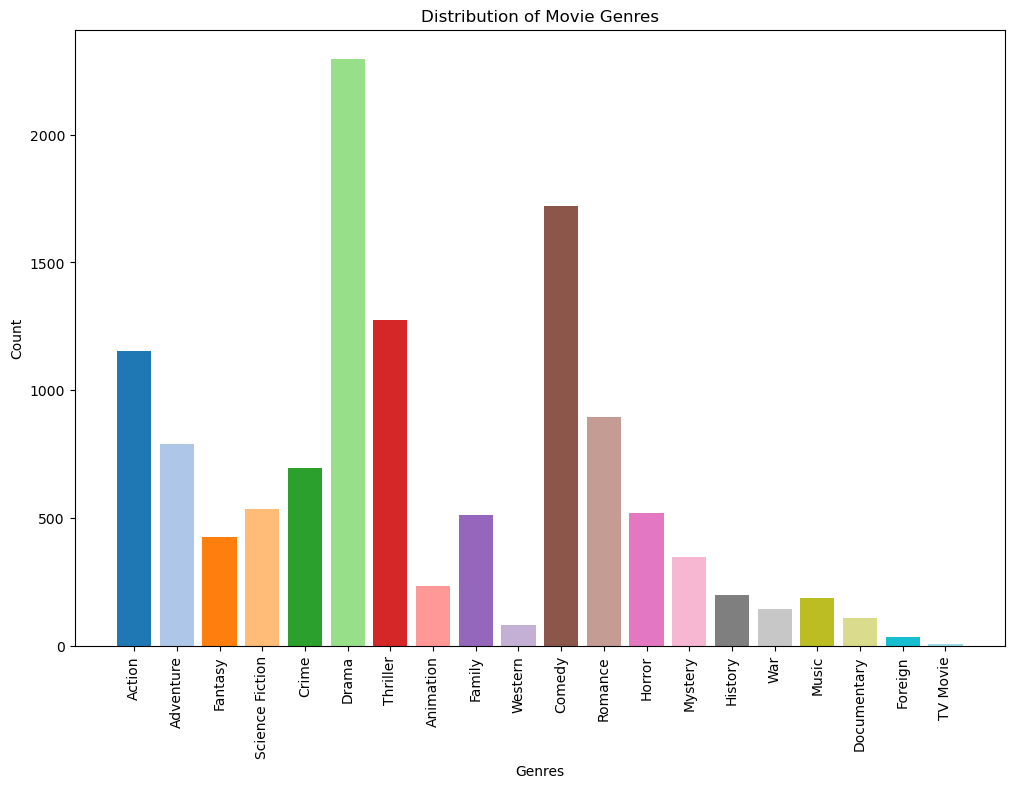

In [57]:
from collections import Counter

# Extract genres from the merged dataframe
movies['genres'] = movies['genres'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
all_genres_merged = movies['genres'].apply(lambda x: [genre['name'] for genre in x] if x else [])
flat_genres_merged = [genre for sublist in all_genres_merged for genre in sublist]

# Count the frequency of each genre in the merged dataframe
genre_counts_merged = Counter(flat_genres_merged)
genres_merged, counts_merged = zip(*genre_counts_merged.items())

# Define a color map for the genres
colors = plt.cm.tab20.colors

# Create the bar plot for the merged dataframe with different colors for each genre
plt.figure(figsize=(12, 8))
plt.bar(genres_merged, counts_merged, color=colors[:len(genres_merged)])
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

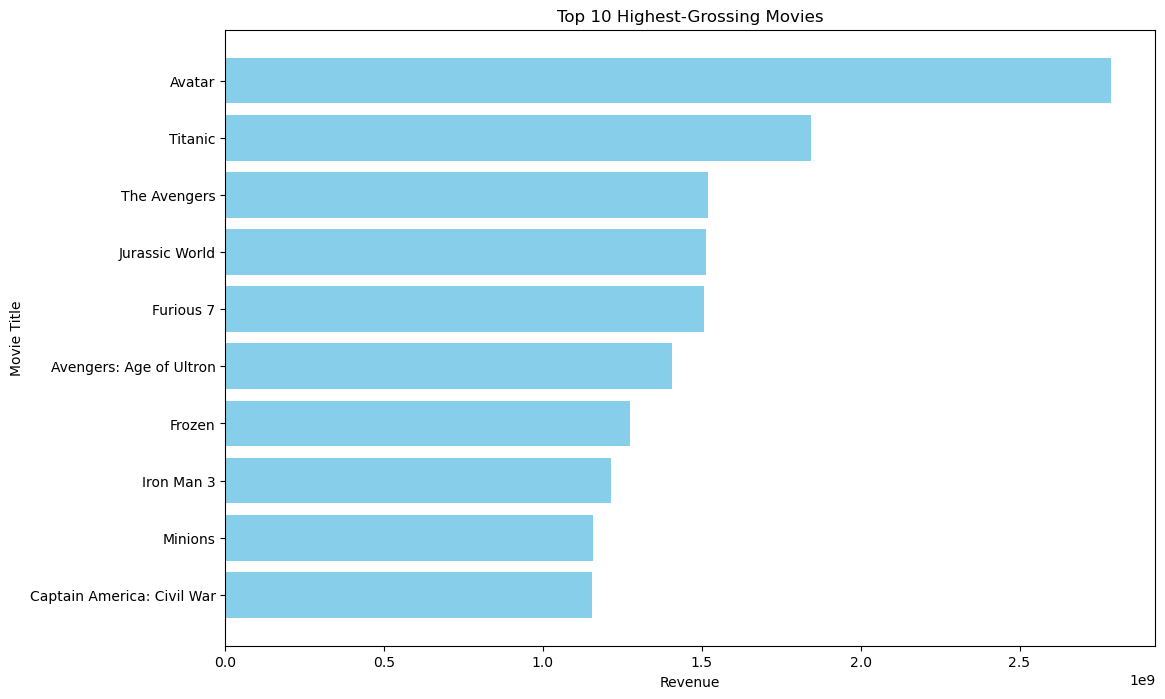

In [61]:
# Get the top 10 highest-grossing movies
top_10_grossing = movies.nlargest(10, 'revenue')[['title_x', 'revenue']]

# Create the bar plot for the top 10 highest-grossing movies
plt.figure(figsize=(12, 8))
plt.barh(top_10_grossing['title_x'], top_10_grossing['revenue'], color='skyblue')
plt.xlabel('Revenue')
plt.ylabel('Movie Title')
plt.title('Top 10 Highest-Grossing Movies')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest-grossing movie at the top
plt.show()


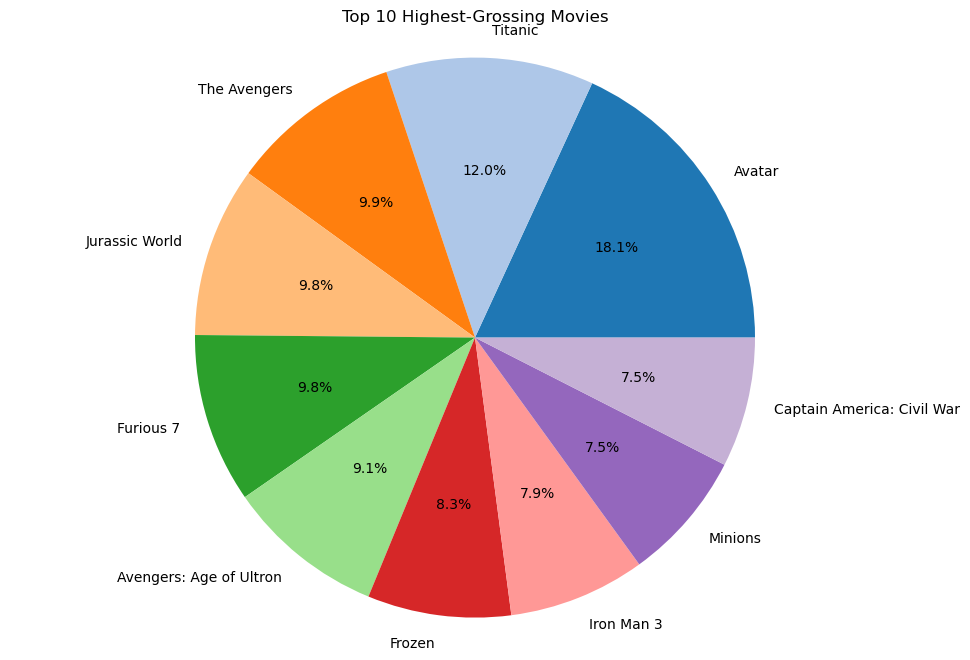

In [62]:
# Create the pie chart for the top 10 highest-grossing movies
plt.figure(figsize=(12, 8))
plt.pie(top_10_grossing['revenue'], labels=top_10_grossing['title_x'], autopct='%.1f%%', colors=plt.cm.tab20.colors)
plt.title('Top 10 Highest-Grossing Movies')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


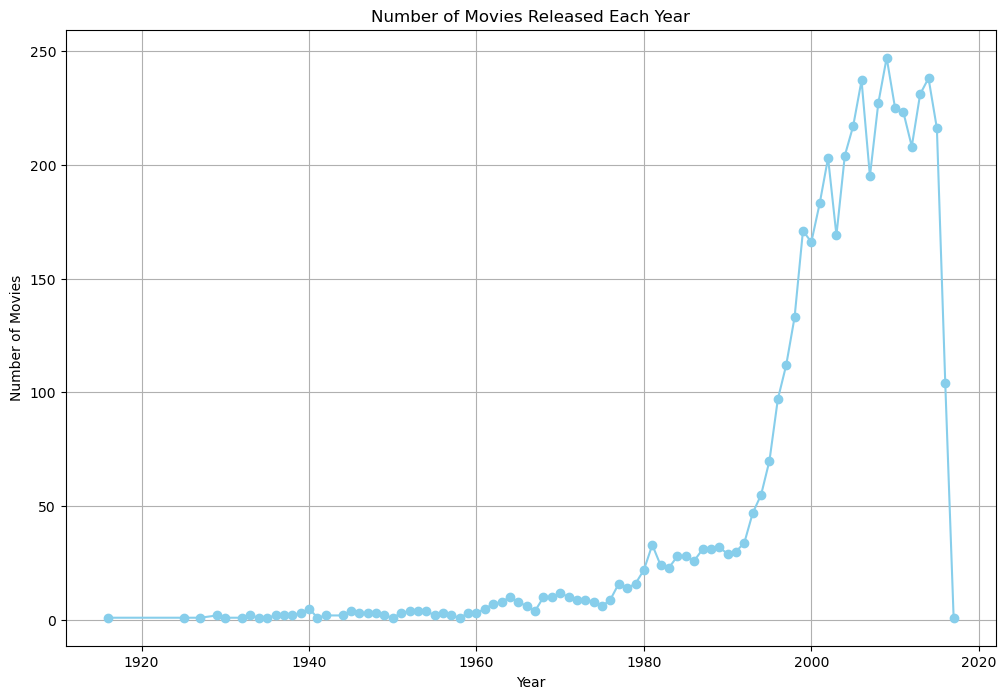

In [64]:
# Extract the year from the release_date column
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year

# Count the number of movies released each year
movies_per_year = movies['release_year'].value_counts().sort_index()

# Create the line plot for the number of movies released each year
plt.figure(figsize=(12, 8))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released Each Year')
plt.grid(True)
plt.show()

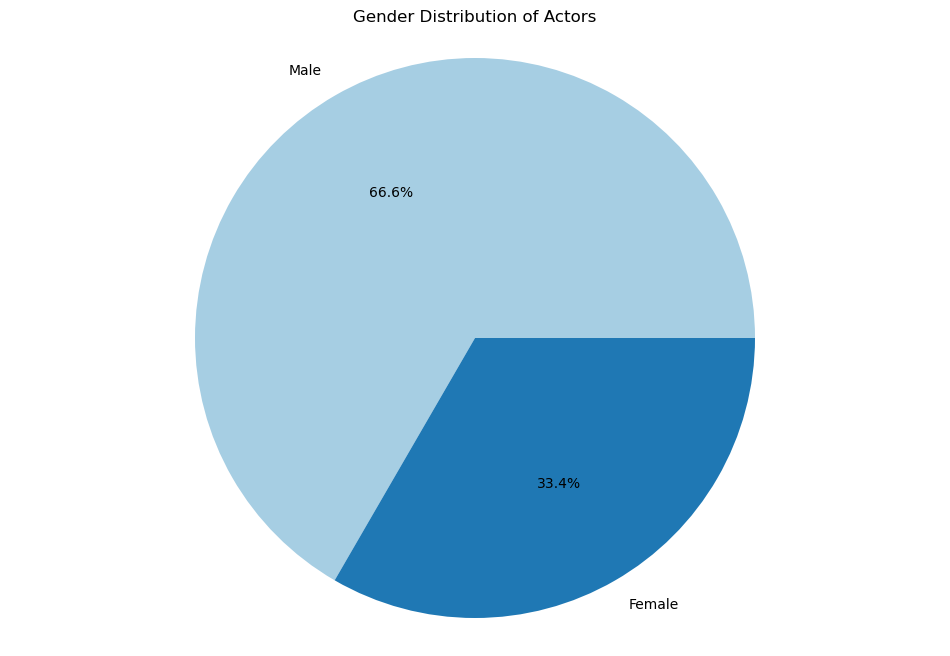

In [65]:
import ast

# Extract and count gender information from the cast column
def extract_genders(cast_data):
    try:
        cast_list = ast.literal_eval(cast_data)
        genders = [person['gender'] for person in cast_list if person['gender'] in [1, 2]]
        return genders
    except (ValueError, SyntaxError):
        return []

# Apply the extraction function to the cast column
movies['cast_genders'] = movies['cast'].apply(extract_genders)

# Flatten the list of genders and count occurrences
all_genders = [gender for sublist in movies['cast_genders'] for gender in sublist]
gender_counts = Counter(all_genders)

# Map gender codes to labels
gender_labels = {1: 'Female', 2: 'Male'}
gender_counts_mapped = {gender_labels[k]: v for k, v in gender_counts.items()}

# Create the pie chart for gender distribution
plt.figure(figsize=(12, 8))
plt.pie(gender_counts_mapped.values(), labels=gender_counts_mapped.keys(), autopct='%.1f%%', colors=plt.cm.Paired.colors)
plt.title('Gender Distribution of Actors')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


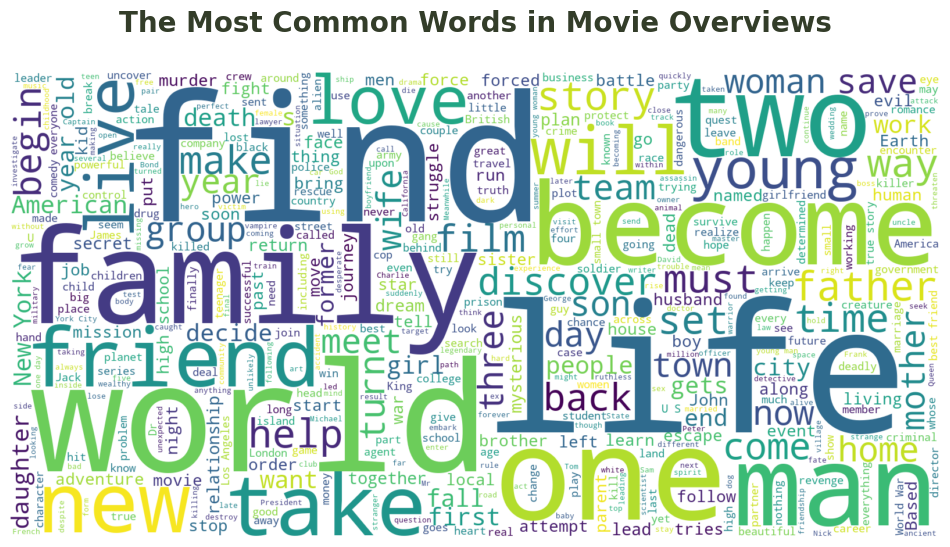

In [66]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate the word cloud
plt.figure(figsize=(12, 10))
plt.title('The Most Common Words in Movie Overviews\n', fontsize=20, weight='bold', color='#333d29')

# Generate the word cloud from the 'overview' column
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color="white").generate(' '.join(movies['overview'].dropna()))

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [72]:
import plotly.express as px
import json
from collections import Counter

# Extract and count production countries
movies['production_countries'] = movies['production_countries'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
all_countries = movies['production_countries'].apply(lambda x: [country['name'] for country in x] if x else [])
flat_countries = [country for sublist in all_countries for country in sublist]

# Count the frequency of each country
country_counts = Counter(flat_countries)
top_countries = country_counts.most_common(10)
countries, counts = zip(*top_countries)

# Create a treemap plot for the top production countries
fig = px.treemap(
    names=countries, 
    parents=["" for _ in countries], 
    values=counts,
    title='Top Production Countries with Highest Number of Movies'
)

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white'
)

fig.show()


# EDA:

In [9]:
# these are the columns I am keeping for recommendation system

movies = movies[['id', 'original_title', 'overview', 'genres', 'keywords','tagline', 'cast', 'crew']]

movies.head()

id                            original_title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   
4   49529                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                              genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                            keywords  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...   
4  [{"id": 818, "name": "based on novel"}, {"id":...   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [10]:
# Missing values
movies.isnull().sum()

id                  0
original_title      0
overview            3
genres              0
keywords            0
tagline           844
cast                0
crew                0
dtype: int64

In [11]:
movies.dropna(inplace=True)

In [12]:
movies.isnull().sum()

id                0
original_title    0
overview          0
genres            0
keywords          0
tagline           0
cast              0
crew              0
dtype: int64

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3959 entries, 0 to 4801
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3959 non-null   int64 
 1   original_title  3959 non-null   object
 2   overview        3959 non-null   object
 3   genres          3959 non-null   object
 4   keywords        3959 non-null   object
 5   tagline         3959 non-null   object
 6   cast            3959 non-null   object
 7   crew            3959 non-null   object
dtypes: int64(1), object(7)
memory usage: 278.4+ KB


In [14]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

- '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

- want to convet these results to ["Action", "Adventure", "Fantasy","Science Fiction"]


In [15]:
# using helper function to get the proper results
def convert(obj):
    L=[]
    for i in obj:
       L.append(i['name']) 
    return L

In [16]:
convert('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

TypeError: string indices must be integers, not 'str'

- **As we can see here, it i not wrking because of 'str', wo we have to convert it to list first with ast**

In [73]:
import ast
ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [18]:
def convert(obj):
    L = []
    # Check if obj is a string, if so, convert it to a list using literal_eval
    if isinstance(obj, str):
        try:
            obj = ast.literal_eval(obj)
        except (ValueError, SyntaxError):
            return []  # Return an empty list if conversion fails
    # Check if obj is a list
    if isinstance(obj, list):
        for i in obj:
            if isinstance(i, dict) and 'name' in i:
                L.append(i['name'])
    return L

movies['genres'] = movies['genres'].apply(convert)

In [19]:
movies['keywords'] = movies['keywords'].apply(convert)

In [20]:
movies['cast']

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4795    [{"cast_id": 2, "character": "The Girl", "cred...
4796    [{"cast_id": 1, "character": "Aaron", "credit_...
4798    [{"cast_id": 1, "character": "El Mariachi", "c...
4799    [{"cast_id": 1, "character": "Buzzy", "credit_...
4801    [{"cast_id": 3, "character": "Sam", "credit_id...
Name: cast, Length: 3959, dtype: object

In [21]:
# I need only top 3 actors in 'cast'

def convert3(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter += 1
        else:
            break
    return L

movies['cast'] =  movies['cast'].apply(convert3)

In [22]:
movies['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [23]:
# the only think we neede here is where the job value is "Director"
def fetch_director(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L

In [24]:
movies['crew']= movies['crew'].apply(fetch_director)

In [25]:
movies.head()

id                            original_title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   
4   49529                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                          genres  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                                            keywords  \
0  [culture clash, future, space war, space colon...   
1  [ocean, drug abuse, exotic island, east india ...   
2  [spy, based on novel, secret agent, sequel, mi...   
3  [dc comics, crime fighter, terrorist, secret i...   
4  [based on novel, mars, medallion, space travel...   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                               cast                 crew  
0  [Sam Worthington, Zoe Saldana, Sigourney Weaver]      [James Cameron]  
1     [Johnny Depp, Orlando Bloom, Keira Knightley]     [Gore Verbinski]  
2      [Daniel Craig, Christoph Waltz, Léa Seydoux]         [Sam Mendes]  
3      [Christian Bale, Michael Caine, Gary Oldman]  [Christopher Nolan]  
4    [Taylor Kitsch, Lynn Collins, Samantha Morton]     [Andrew Stanton]

In [26]:
# converting the list into str
movies ['genres'] = movies ['genres'].apply(lambda x: " ".join(x))
movies ['keywords'] = movies ['keywords'].apply(lambda x: " ".join(x))
movies ['cast'] = movies ['cast'].apply(lambda x: " ".join(x))
movies ['crew'] = movies ['crew'].apply(lambda x: " ".join(x))

In [27]:
movies.head()

id                            original_title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   
4   49529                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                     genres  \
0  Action Adventure Fantasy Science Fiction   
1                  Adventure Fantasy Action   
2                    Action Adventure Crime   
3               Action Crime Drama Thriller   
4          Action Adventure Science Fiction   

                                            keywords  \
0  culture clash future space war space colony so...   
1  ocean drug abuse exotic island east india trad...   
2  spy based on novel secret agent sequel mi6 bri...   
3  dc comics crime fighter terrorist secret ident...   
4  based on novel mars medallion space travel pri...   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                           cast               crew  
0  Sam Worthington Zoe Saldana Sigourney Weaver      James Cameron  
1     Johnny Depp Orlando Bloom Keira Knightley     Gore Verbinski  
2      Daniel Craig Christoph Waltz Léa Seydoux         Sam Mendes  
3      Christian Bale Michael Caine Gary Oldman  Christopher Nolan  
4    Taylor Kitsch Lynn Collins Samantha Morton     Andrew Stanton

In [40]:
# Extract relevant features and combine them into a single string
def combine_features(row):
    features = []
    features.append(row['genres'])
    features.append(row['keywords'])
    features.append(row['overview'])
    features.append(row['cast'])
    features.append(row['crew'])
    return ' '.join(features)


In [41]:
movies['combined_features'] = movies.apply(combine_features, axis=1)

In [42]:
movies.head()

id                            original_title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   
4   49529                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                     genres  \
0  Action Adventure Fantasy Science Fiction   
1                  Adventure Fantasy Action   
2                    Action Adventure Crime   
3               Action Crime Drama Thriller   
4          Action Adventure Science Fiction   

                                            keywords  \
0  culture clash future space war space colony so...   
1  ocean drug abuse exotic island east india trad...   
2  spy based on novel secret agent sequel mi6 bri...   
3  dc comics crime fighter terrorist secret ident...   
4  based on novel mars medallion space travel pri...   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                           cast               crew  \
0  Sam Worthington Zoe Saldana Sigourney Weaver      James Cameron   
1     Johnny Depp Orlando Bloom Keira Knightley     Gore Verbinski   
2      Daniel Craig Christoph Waltz Léa Seydoux         Sam Mendes   
3      Christian Bale Michael Caine Gary Oldman  Christopher Nolan   
4    Taylor Kitsch Lynn Collins Samantha Morton     Andrew Stanton   

                                   combined_features  
0  Action Adventure Fantasy Science Fiction cultu...  
1  Adventure Fantasy Action ocean drug abuse exot...  
2  Action Adventure Crime spy based on novel secr...  
3  Action Crime Drama Thriller dc comics crime fi...  
4  Action Adventure Science Fiction based on nove...

In [43]:
# Vectorize the combined features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = vectorizer.fit_transform(movies['combined_features'])

In [44]:
# Train the Nearest Neighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(feature_vectors)

NearestNeighbors(algorithm='brute', metric='cosine')

In [45]:
# Define the recommendation function with various search filters
def recommend_movies(search_term, n_recommendations=5):
    search_vector = vectorizer.transform([search_term])
    distances, indices = model.kneighbors(search_vector, n_neighbors=n_recommendations + 1)
    recommended_movies = movies.iloc[indices[0][1:]]['original_title']
    return recommended_movies

In [48]:
# Searching by genre
print("Movies related to 'Action' genre:")
print(recommend_movies('Action', 5))

# Searching by title
print("\nMovies related to 'Avatar' title:")
print(recommend_movies('Avatar', 5))

# Searching by keywords
print("\nMovies related to 'alien' keyword:")
print(recommend_movies('alien', 5))

# Searching by production company
print("\nMovies related to 'Walt Disney' production company:")
print(recommend_movies('Walt Disney', 5))

Movies related to 'Action' genre:
4638      Amidst the Devil's Wings
127             Mad Max: Fury Road
355     Die Hard: With a Vengeance
3051                     MacGruber
741                        Shooter
Name: original_title, dtype: object

Movies related to 'Avatar' title:
4668      The Stewardesses
4398      Creative Control
2915                 Trash
2918    Jackass Number Two
2913         Dirty Grandpa
Name: original_title, dtype: object

Movies related to 'alien' keyword:
1201           Predators
141      Mars Needs Moms
74      Edge of Tomorrow
502         The Invasion
1326        The 5th Wave
Name: original_title, dtype: object

Movies related to 'Walt Disney' production company:
1386               Saving Mr. Banks
846                    Stuck on You
2577               Tuck Everlasting
2994           Recess: School's Out
3424    The Adventures of Huck Finn
Name: original_title, dtype: object


In [47]:
import pickle

# Save the trained model
with open('nearest_neighbors_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)